# Distributed Deep Q-Learning 

The goal of this assignment is to implement and experiment with both single-core and distributed versions of the deep reinforcement learning algorithm Deep Q Networks (DQN). In particular, DQN will be run in the classic RL benchmark Cart-Pole and abblation experiments will be run to observe the impact of the different DQN components. 

The relevant content about DQN can be found Q-Learning and SARSA are in the following course notes from CS533.

https://oregonstate.instructure.com/courses/1719746/files/75047394/download?wrap=1

The full pseudo-code for DQN is on slide 45 with prior slides introducing the individual components. 


## Recap of DQN 

From the course slides it can be seen that DQN is simply the standard table-based Q-learning algorithm but with three extensions:

1) Use of function approximation via a neural network instead of a Q-table. 
2) Use of experience replay. 
3) Use of a target network. 

Extension (1) allows for scaling to problems with enormous state spaces, such as when the states correspond to images or sequences of images. Extensions (2) and (3) are claimed to improve the robustness and effectiveness of DQN compared. 

(2) adjusts Q-learning so that updates are not just performed on individual experiences as they arrive. But rather, experiences are stored in a memory buffer and updates are performed by sampling random mini-batches of experience tuples from the memory buffer and updating the network based on the mini-batch. This allows for reuse of experience as well as helping to reduce correlation between successive updates, which is claimed to be beneficial. 

(3) adjusts the way that target values are computed for the Q-learning updates. Let $Q_{\theta}(s,a)$ be the function approximation network with parameters $\theta$ for representing the Q-function. Given an experience tuple $(s, a, r, s')$ the origional Q-learning algorithm updates the parameters so that $Q_{\theta}(s,a)$ moves closer to the target value: 
\begin{equation}
r + \beta \max_a' Q_{\theta}(s',a') 
\end{equation}
Rather, DQN stores two function approximation networks. The first is the update network with parameters $\theta$, which is the network that is continually updated during learning. The second is a target network with parameters $\theta'$. Given the same experience tuple, DQN will update the parameters $\theta$ so that $Q_{\theta}(s,a)$ moves toward a target value based on the target network:
\begin{equation}
r + \beta \max_a' Q_{\theta'}(s',a') 
\end{equation}
Periodically the target network is updated with the most recent parameters $\theta' \leftarrow \theta$. This use of a target network is claimed to stabilize learning.

In the assignment you will get to see an example of the impact of both the target network and experience replay.

Further reading about DQN and its application to learning to play Atari games can be found in the following paper. 

Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A.A., Veness, J., Bellemare, M.G., Graves, A., Riedmiller, M., Fidjeland, A.K., Ostrovski, G. and Petersen, S., 2015. Human-level control through deep reinforcement learning. Nature, 518(7540), p.529.
https://oregonstate.instructure.com/courses/1719746/files/75234294/download?wrap=1

In [1]:
#!pip3 install --user gym[Box2D]
#!pip3 install --user torch
#!pip3 install --user JSAnimation
#!pip3 install --user matplotlib

Install the packages for enviroment

In [2]:
import gym
import torch
import time
import os
import ray
import numpy as np

from tqdm import tqdm
from random import uniform, randint

import io
import base64
from IPython.display import HTML

from dqn_model import DQNModel
from dqn_model import _DQNModel
from memory import ReplayBuffer

import matplotlib.pyplot as plt
%matplotlib inline

FloatTensor = torch.FloatTensor

## Useful PyTorch functions

### Tensors

This assignment will use the PyTorch library for the required neural network functionality. You do not need to be familiar with the details of PyTorch or neural network training. However, the assignment will require dealing with data in the form of tensors.  

The mini-batches used to train the PyTorch neural network is expected to be represented as a tensor matrix. The function `FloatTensor` can convert a list or NumPy matrix into a tensor matrix if needed. 

You can find more infomation here: https://pytorch.org/docs/stable/tensors.html

In [3]:
# list
m = [[3,2,1],[6,4,5],[7,8,9]]
print(m)

# tensor matrix
m_tensor = FloatTensor(m)
print(type(m_tensor))
print(m_tensor)


l = [[9,5,13],[0,1,2],[2,0,1]]
print(l)

# tensor matrix
l_tensor = FloatTensor(l)
print(type(l_tensor))
print(l_tensor)

[[3, 2, 1], [6, 4, 5], [7, 8, 9]]
<class 'torch.Tensor'>
tensor([[3., 2., 1.],
        [6., 4., 5.],
        [7., 8., 9.]])
[[9, 5, 13], [0, 1, 2], [2, 0, 1]]
<class 'torch.Tensor'>
tensor([[ 9.,  5., 13.],
        [ 0.,  1.,  2.],
        [ 2.,  0.,  1.]])


### Tensor.max()
Once you have a tenosr maxtrix, you can use torch.max(m_tensor, dim) to get the max value and max index corresponding to the dimension you choose.
```
>>> a = torch.randn(4, 4)
>>> a
tensor([[-1.2360, -0.2942, -0.1222,  0.8475],
        [ 1.1949, -1.1127, -2.2379, -0.6702],
        [ 1.5717, -0.9207,  0.1297, -1.8768],
        [-0.6172,  1.0036, -0.6060, -0.2432]])
>>> torch.max(a, 1)
torch.return_types.max(values=tensor([0.8475, 1.1949, 1.5717, 1.0036]), indices=tensor([3, 0, 0, 1]))
```
You can find more infomation here: https://pytorch.org/docs/stable/torch.html#torch.max

In [4]:
max_value, index = torch.max(m_tensor, dim = 1)
print(max_value, index)
print(torch.max(max_value, dim = 0))

tensor([3., 6., 9.]) tensor([0, 0, 2])
torch.return_types.max(
values=tensor(9.),
indices=tensor(2))


## Initialize Environment
### CartPole-v0:  
CartPole is a classic control task that is often used as an introductory reinforcement learning benchmark. The environment involves controlling a 2d cart that can move in either the left or right direction on a frictionless track. A pole is attached to the cart via an unactuated joint. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.  
(You can find more infomation by this Link: https://gym.openai.com/envs/CartPole-v0/)  
  


In [5]:
# Set the Env name and action space for CartPole
ENV_NAME = 'CartPole-v0'
# Move left, Move right
ACTION_DICT = {
    "LEFT": 0,
    "RIGHT":1
}
# Register the environment
env_CartPole = gym.make(ENV_NAME)

In [6]:
# Set result saveing floder
result_floder = ENV_NAME
result_file = ENV_NAME + "/results.txt"
if not os.path.isdir(result_floder):
    os.mkdir(result_floder)

## Helper Function
Plot results.

In [7]:
def plot_result(total_rewards ,learning_num, legend):
    print("\nLearning Performance:\n")
    episodes = []
    for i in range(len(total_rewards)):
        episodes.append(i * learning_num + 1)
        
    plt.figure(num = 1)
    fig, ax = plt.subplots()
    plt.plot(episodes, total_rewards)
    plt.title('performance')
    plt.legend(legend)
    plt.xlabel("Episodes")
    plt.ylabel("total rewards")
    plt.show()

## Hyperparams
When function approximation is involves, especially neural networks, additional hyper parameters are inroduced and setting the parameters can require experience. Below is a list of the hyperparameters used in this assignment and values for the parameters that have worked well for a basic DQN implementation. You will adjust these values for particular parts of the assignment. For example, experiments that do not use the target network will set 'use_target_model' to False. 

You can find the more infomation about these hyperparameters in the notation of DQN_agent.init() function.

In [8]:
hyperparams_CartPole = {
    'epsilon_decay_steps' : 100000, 
    'final_epsilon' : 0.1,
    'batch_size' : 32, 
    'update_steps' : 10, 
    'memory_size' : 2000, 
    'beta' : 0.99, 
    'model_replace_freq' : 2000,
    'learning_rate' : 0.0003,
    'use_target_model': True
}

***
# Part 1: Non-distributed DQN

In this part, you will complete an implementation of DQN and run experiments on the CartPole environment from OpenAI Gym.  
Note that OpenAI Gym has many other environments that use the same interface---so this experience will allow the curious student to easily explore these algorithms more widely. 

Below you need to fill in the missing code for the DQN implementation. 

The Run function below can then be used to generate learning curves. 

You should conduct the following experiments involving different features of DQN. 

1. DQN without a replay buffer and without a target network. This is just standard Q-learning with a function approximator.
    The corresponding parameters are: memory_size = 1, update_steps = 1, batch_size = 1, use_target_model = False  
    
2. DQN without a replay buffer (but including the target network).   
    The corresponding parameters are: memory_size = 1, update_steps = 1, batch_size = 1, use_target_model = True  

3. DQN with a replay buffer, but without a target network.   
    Here you set use_target_model = False and otherwise set the replay memory parameters to the above suggested values 
   
4. Full DQN

For each experiment, record the parameters that you used, plot the resulting learning curves, and give a summary of your observations regarding the differences you observed. 
***



## DQN Agent

The full DQN agent involves a number of functions, the neural network, and the replay memory. Interfaces to a neural network model and memory are provided. 

Some useful information is below:   
- Neural Network Model: The network is used to represent the Q-function $Q(s,a)$. It takes a state $s$ as input and returns a vector of Q-values, one value for each action. The following interface functions are used for predicting Q-values, actions, and updating the neural network model parameters. 
    1. Model.predict(state) --- Returns the action that has the best Q-value in 'state'.
    2. Model.predict_batch(states) --- This is used to predict both the Q-values and best actions for a batch of states. Given a batch of states, the function returns: 1) 'best_actions' a vector containing the best action for each input state, and 2) 'q_values' a matrix where each row gives the Q-value for all actions of each state (one row per state).   
    3. Model.fit(q_values, q_target) --- It is used to update the neural network (via back-propagation). 'q_values' is a vector containing the Q-value predictions for a list of state-action pairs (e.g. from a batch of experience tuples). 'q_target' is a vector containing target values that we would like the correspoinding predictions to get closer to. This function updates the network in a way that the network predictions will ideally be closer to the targets. There is no return value.  
    4. Model.replace(another_model) --- It takes another model as input, and replace the weight of itself by the input model.
- Memory: This is the buffer used to store experience tuples for experience replay.
    1. Memory.add(state, action, reward, state', is_terminal) --- It takes one example as input, and store it into its storage.  
    2. Memory.sample(batch_size) --- It takes a batch_size int number as input. Return 'batch_size' number of randomly selected examples from the current memory buffer. The batch takes the form (states, actions, rewards, states', is_terminals) with each component being a vector/list of size equal to batch_size. 

In [9]:
class DQN_agent(object):
    def __init__(self, env, hyper_params, action_space = len(ACTION_DICT)):
        
        self.env = env
        self.max_episode_steps = env._max_episode_steps
        
        """
            beta: The discounted factor of Q-value function
            (epsilon): The explore or exploit policy epsilon. 
            initial_epsilon: When the 'steps' is 0, the epsilon is initial_epsilon, 1
            final_epsilon: After the number of 'steps' reach 'epsilon_decay_steps', 
                The epsilon set to the 'final_epsilon' determinately.
            epsilon_decay_steps: The epsilon will decrease linearly along with the steps from 0 to 'epsilon_decay_steps'.
        """
        self.beta = hyper_params['beta']
        self.initial_epsilon = 1
        self.final_epsilon = hyper_params['final_epsilon']
        self.epsilon_decay_steps = hyper_params['epsilon_decay_steps']

        """
            episode: Record training episode
            steps: Add 1 when predicting an action
            learning: The trigger of agent learning. It is on while training agent. It is off while testing agent.
            action_space: The action space of the current environment, e.g 2.
        """
        self.episode = 0
        self.steps = 0
        self.best_reward = 0
        self.learning = True
        self.action_space = action_space

        """
            input_len The input length of the neural network. It equals to the length of the state vector.
            output_len: The output length of the neural network. It is equal to the action space.
            eval_model: The model for predicting action for the agent.
            target_model: The model for calculating Q-value of next_state to update 'eval_model'.
            use_target_model: Trigger for turn 'target_model' on/off
        """
        state = env.reset()
        input_len = len(state)
        output_len = action_space
        self.eval_model = DQNModel(input_len, output_len, learning_rate = hyper_params['learning_rate'])
        self.use_target_model = hyper_params['use_target_model']
        if self.use_target_model:
            self.target_model = DQNModel(input_len, output_len)
#         memory: Store and sample experience replay.
        self.memory = ReplayBuffer(hyper_params['memory_size'])
        
        """
            batch_size: Mini batch size for training model.
            update_steps: The frequence of traning model
            model_replace_freq: The frequence of replacing 'target_model' by 'eval_model'
        """
        self.batch_size = hyper_params['batch_size']
        self.update_steps = hyper_params['update_steps']
        self.model_replace_freq = hyper_params['model_replace_freq']
        
    # Linear decrease function for epsilon
    def linear_decrease(self, initial_value, final_value, curr_steps, final_decay_steps):
        decay_rate = curr_steps / final_decay_steps
        if decay_rate > 1:
            decay_rate = 1
        return initial_value - (initial_value - final_value) * decay_rate
    
    def explore_or_exploit_policy(self, state):
        p = uniform(0, 1)
        # Get decreased epsilon
        epsilon = self.linear_decrease(self.initial_epsilon, 
                               self.final_epsilon,
                               self.steps,
                               self.epsilon_decay_steps)
        
        if p < epsilon:
            #return action
            return randint(0, self.action_space - 1)
        else:
            #return action
            return self.greedy_policy(state)
        
    def greedy_policy(self, state):
        return self.eval_model.predict(state)
    
    # This next function will be called in the main RL loop to update the neural network model given a batch of experience
    # 1) Sample a 'batch_size' batch of experiences from the memory.
    # 2) Predict the Q-value from the 'eval_model' based on (states, actions)
    # 3) Predict the Q-value from the 'target_model' base on (next_states), and take the max of each Q-value vector, Q_max
    # 4) If is_terminal == 1, q_target = reward, otherwise q_target = reward + discounted factor * Q_max
    # 5) Call fit() to do the back-propagation for 'eval_model'.
    def update_batch(self):
        if len(self.memory) < self.batch_size or self.steps % self.update_steps != 0:
            return

        batch = self.memory.sample(self.batch_size)

        (states, actions, reward, next_states,
         is_terminal) = batch
        
        states = states
        next_states = next_states
        terminal = FloatTensor([1 if t else 0 for t in is_terminal])
        reward = FloatTensor(reward)
        batch_index = torch.arange(self.batch_size,
                                   dtype=torch.long)
        
        # Current Q Values
        _, q_values = self.eval_model.predict_batch(states)
        q_values = q_values[batch_index, actions]
        
        # Calculate target
        if self.use_target_model:
            actions, q_next = self.target_model.predict_batch(next_states)
        else:
            actions, q_next = self.eval_model.predict_batch(next_states)
            
        q_max, indices = torch.max(q_next, dim = 1)
            
        #INSERT YOUR CODE HERE --- neet to compute 'q_targets' used below
        q_targets = []
        for i, is_term in enumerate(terminal):
            if is_term == 1:
                q_targets.append(reward[i])
            else:
                q_targets.append(reward[i] + self.beta * q_max[i])
        
        q_targets_tensor = FloatTensor(q_targets)
            
        # update model
        self.eval_model.fit(q_values, q_targets_tensor)
    
    def learn_and_evaluate(self, training_episodes, test_interval):
        test_number = training_episodes // test_interval
        all_results = []
        
        for i in range(test_number):
            # learn
            self.learn(test_interval)
            
            # evaluate
            avg_reward = self.evaluate()
            all_results.append(avg_reward)
            
        return all_results
    
    def learn(self, test_interval):
        for episode in tqdm(range(test_interval), desc="Training"):
            state = self.env.reset()
            done = False
            steps = 0
            self.episode += 1
            
            if self.use_target_model == True:
                while steps < self.max_episode_steps and not done:
                    #INSERT YOUR CODE HERE
                    # add experience from explore-exploit policy to memory
                    # update the model every 'update_steps' of experience
                    # update the target network (if the target network is being used) every 'model_replace_freq' of experiences 
                    action = self.explore_or_exploit_policy(state)
                    obs_state, reward, done, _ = self.env.step(action)
                    self.memory.add(state, action, reward, obs_state, done)

                    self.steps += 1
                    steps += 1

                    if self.steps % self.update_steps == 0:
                        self.update_batch()

                    if self.steps % self.model_replace_freq == 0:
                        self.target_model.replace(self.eval_model)
                    state = obs_state
            
            else:
                while steps < self.max_episode_steps and not done:
                    #INSERT YOUR CODE HERE
                    # add experience from explore-exploit policy to memory
                    # update the model every 'update_steps' of experience
                    # update the target network (if the target network is being used) every 'model_replace_freq' of experiences 
                    action = self.explore_or_exploit_policy(state)
                    obs_state, reward, done, _ = self.env.step(action)
                    self.memory.add(state, action, reward, obs_state, done)

                    self.steps += 1
                    steps += 1

                    if self.steps % self.update_steps == 0:
                        self.update_batch()
                    state = obs_state
                
                
    def evaluate(self, trials = 30):
        total_reward = 0
        for _ in tqdm(range(trials), desc="Evaluating"):
            state = self.env.reset()
            done = False
            steps = 0

            while steps < self.max_episode_steps and not done:
                steps += 1
                action = self.greedy_policy(state)
                state, reward, done, _ = self.env.step(action)
                total_reward += reward

        avg_reward = total_reward / trials
        print(avg_reward)
        f = open(result_file, "a+")
        f.write(str(avg_reward) + "\n")
        f.close()
        if avg_reward >= self.best_reward:
            self.best_reward = avg_reward
            self.save_model()
        return avg_reward

    # save model
    def save_model(self):
        self.eval_model.save(result_floder + '/best_model.pt')
        
    # load model
    def load_model(self):
        self.eval_model.load(result_floder + '/best_model.pt')

## Run function

Training:   8%|▊         | 4/50 [00:00<00:01, 37.60it/s]

10.066666666666666


Training:  10%|█         | 5/50 [00:00<00:01, 41.04it/s]

9.3


Training:  10%|█         | 5/50 [00:00<00:01, 42.03it/s]

9.166666666666666


Training:   6%|▌         | 3/50 [00:00<00:02, 22.78it/s]

9.366666666666667


Training:   4%|▍         | 2/50 [00:00<00:02, 16.24it/s]

9.1


Training:   8%|▊         | 4/50 [00:00<00:01, 38.92it/s]

9.2


Training:   8%|▊         | 4/50 [00:00<00:01, 35.02it/s]

9.166666666666666


Training:   8%|▊         | 4/50 [00:00<00:01, 33.62it/s]

9.433333333333334


Training:   6%|▌         | 3/50 [00:00<00:01, 29.53it/s]

9.233333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 18.77it/s]

9.333333333333334


Training:   4%|▍         | 2/50 [00:00<00:02, 19.42it/s]

9.3


Training:   8%|▊         | 4/50 [00:00<00:01, 37.07it/s]

9.4


Training:  10%|█         | 5/50 [00:00<00:01, 44.53it/s]

9.2


Training:   6%|▌         | 3/50 [00:00<00:02, 20.22it/s]

9.166666666666666


Training:  10%|█         | 5/50 [00:00<00:01, 32.13it/s]

9.333333333333334


Training:   6%|▌         | 3/50 [00:00<00:02, 22.40it/s]

80.9


Training:   8%|▊         | 4/50 [00:00<00:01, 31.61it/s]

9.3


Training:   6%|▌         | 3/50 [00:00<00:02, 21.05it/s]

138.06666666666666


Training:  10%|█         | 5/50 [00:00<00:01, 41.08it/s]

9.233333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 16.37it/s]

117.66666666666667


Training:   4%|▍         | 2/50 [00:00<00:02, 16.71it/s]

14.933333333333334


Training:   8%|▊         | 4/50 [00:00<00:01, 31.97it/s]

11.266666666666667


Training:   4%|▍         | 2/50 [00:00<00:03, 13.32it/s]

21.366666666666667


Training:   4%|▍         | 2/50 [00:00<00:02, 18.90it/s]

94.06666666666666


Training:   8%|▊         | 4/50 [00:00<00:01, 37.91it/s]

96.73333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

177.83333333333334


Training:   2%|▏         | 1/50 [00:00<00:07,  6.51it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  8.02it/s]

200.0


Training:   6%|▌         | 3/50 [00:00<00:02, 21.19it/s]

176.43333333333334


Training:   2%|▏         | 1/50 [00:00<00:06,  7.87it/s]

116.86666666666666


Training:   4%|▍         | 2/50 [00:00<00:03, 12.74it/s]

80.73333333333333


Training:   8%|▊         | 4/50 [00:00<00:01, 38.46it/s]

75.83333333333333


Training:   8%|▊         | 4/50 [00:00<00:02, 21.20it/s]

71.16666666666667


Training:   4%|▍         | 2/50 [00:00<00:03, 15.86it/s]

85.63333333333334


Training:   4%|▍         | 2/50 [00:00<00:03, 14.68it/s]

64.8


Training:   4%|▍         | 2/50 [00:00<00:03, 12.31it/s]

64.1


Training:   8%|▊         | 4/50 [00:00<00:01, 35.48it/s]

37.03333333333333


Training:   8%|▊         | 4/50 [00:00<00:01, 36.51it/s]

22.633333333333333


Training:   4%|▍         | 2/50 [00:00<00:04, 11.20it/s]

82.9


Training:   6%|▌         | 3/50 [00:00<00:01, 27.98it/s]

97.16666666666667


Training:   4%|▍         | 2/50 [00:00<00:02, 16.28it/s]

89.6


Training:   6%|▌         | 3/50 [00:00<00:01, 27.24it/s]

103.26666666666667


Training:   2%|▏         | 1/50 [00:00<00:09,  5.22it/s]

144.06666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

9.566666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:02, 19.42it/s]

43.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:08,  5.86it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.66it/s]

78.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

94.43333333333334


Training:  14%|█▍        | 7/50 [00:00<00:00, 67.83it/s]

9.366666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

15.433333333333334


Training:   2%|▏         | 1/50 [00:00<00:07,  6.21it/s]

144.3


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  5.47it/s]

85.53333333333333


Training:  14%|█▍        | 7/50 [00:00<00:00, 68.80it/s]

9.566666666666666


Training:   4%|▍         | 2/50 [00:00<00:03, 13.99it/s]

89.93333333333334


Training:   2%|▏         | 1/50 [00:00<00:06,  7.15it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 15.46it/s]

47.666666666666664


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.82it/s]

43.266666666666666


Training:   4%|▍         | 2/50 [00:00<00:02, 18.94it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  5.96it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

92.43333333333334


Training:   2%|▏         | 1/50 [00:00<00:07,  6.69it/s]

102.4


Training:   2%|▏         | 1/50 [00:00<00:06,  7.90it/s]

71.43333333333334


Training:  12%|█▏        | 6/50 [00:00<00:00, 55.53it/s]

132.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  8.88it/s]

72.93333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

66.3


Training:   0%|          | 0/50 [00:00<?, ?it/s]

161.23333333333332


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:02, 18.91it/s]

40.6


Training:   0%|          | 0/50 [00:00<?, ?it/s]

9.466666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

102.73333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  8.47it/s]

76.93333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  5.99it/s]

132.43333333333334


Training:   2%|▏         | 1/50 [00:00<00:07,  6.32it/s]

102.66666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

159.46666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  9.40it/s]

80.26666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  9.30it/s]

68.33333333333333


Training:   4%|▍         | 2/50 [00:00<00:03, 13.96it/s]

46.96666666666667


Training:   2%|▏         | 1/50 [00:00<00:08,  5.96it/s]

111.5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.40it/s]

146.0


Training:   4%|▍         | 2/50 [00:00<00:03, 12.71it/s]

60.4


Training:   4%|▍         | 2/50 [00:00<00:02, 17.96it/s]

63.8


Training:   2%|▏         | 1/50 [00:00<00:07,  6.68it/s]

113.23333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

111.83333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

86.56666666666666


Training:   4%|▍         | 2/50 [00:00<00:02, 19.37it/s]

14.433333333333334


Training:   6%|▌         | 3/50 [00:00<00:02, 21.85it/s]

64.16666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  9.38it/s]

49.8


Training:   0%|          | 0/50 [00:00<?, ?it/s]

65.7


Training:   2%|▏         | 1/50 [00:00<00:05,  8.77it/s]

78.26666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  8.38it/s]

83.9


Training:   2%|▏         | 1/50 [00:00<00:09,  5.36it/s]

96.3


Training:  12%|█▏        | 6/50 [00:00<00:00, 50.57it/s]

58.63333333333333


Training:   2%|▏         | 1/50 [00:00<00:07,  6.55it/s]

92.26666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

97.13333333333334


Training:   2%|▏         | 1/50 [00:00<00:06,  7.06it/s]

96.4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

66.53333333333333


Training:   2%|▏         | 1/50 [00:00<00:07,  6.45it/s]

61.53333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

174.33333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

21.366666666666667


Training:   2%|▏         | 1/50 [00:00<00:06,  7.64it/s]

112.86666666666666


Training:   2%|▏         | 1/50 [00:00<00:05,  8.30it/s]

58.13333333333333


Training:   6%|▌         | 3/50 [00:00<00:03, 15.61it/s]

9.466666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

55.4


Training:   4%|▍         | 2/50 [00:00<00:04, 11.03it/s]

48.8


Training:   6%|▌         | 3/50 [00:00<00:02, 18.00it/s]

23.266666666666666


Training:   2%|▏         | 1/50 [00:00<00:08,  5.72it/s]

123.03333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

32.53333333333333


Training:  12%|█▏        | 6/50 [00:00<00:00, 54.84it/s]

9.433333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

59.7


Training:   2%|▏         | 1/50 [00:00<00:06,  7.43it/s]

90.53333333333333


Training:   2%|▏         | 1/50 [00:00<00:08,  5.87it/s]

78.7


Training:   2%|▏         | 1/50 [00:00<00:06,  7.28it/s]

108.6


Training:   2%|▏         | 1/50 [00:00<00:06,  7.51it/s]

92.96666666666667


Training:   2%|▏         | 1/50 [00:00<00:08,  5.47it/s]

45.96666666666667


Training:   2%|▏         | 1/50 [00:00<00:06,  7.75it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

180.7


Training:   6%|▌         | 3/50 [00:00<00:02, 20.02it/s]

33.56666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  9.18it/s]

38.333333333333336


Training:   0%|          | 0/50 [00:00<?, ?it/s]

170.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 11.36it/s]

91.4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

77.2


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   8%|▊         | 4/50 [00:00<00:01, 39.09it/s]

16.366666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

9.233333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

9.533333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

14.633333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

41.833333333333336


Training:   0%|          | 0/50 [00:00<?, ?it/s]

79.1


Training:   2%|▏         | 1/50 [00:00<00:05,  8.89it/s]

75.56666666666666


Training:   2%|▏         | 1/50 [00:00<00:06,  7.60it/s]

83.6


Training:   2%|▏         | 1/50 [00:00<00:05,  8.82it/s]

73.96666666666667


Training:   2%|▏         | 1/50 [00:00<00:07,  6.42it/s]

96.9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

9.4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  5.72it/s]

115.73333333333333


Training:   2%|▏         | 1/50 [00:00<00:06,  7.00it/s]

85.96666666666667


Training:   4%|▍         | 2/50 [00:00<00:03, 14.80it/s]

49.5


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

193.73333333333332


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.14it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

88.23333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 17.99it/s]

36.06666666666667


Training:   4%|▍         | 2/50 [00:00<00:02, 19.33it/s]

32.36666666666667


Training:   2%|▏         | 1/50 [00:00<00:08,  5.65it/s]

132.16666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

139.06666666666666


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 38.07it/s]


200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

9.2


Training:   4%|▍         | 2/50 [00:00<00:03, 15.44it/s]

136.23333333333332


Training:   0%|          | 0/50 [00:00<?, ?it/s]

66.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  8.96it/s]

111.73333333333333


Training:   6%|▌         | 3/50 [00:00<00:02, 18.57it/s]

19.266666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

9.266666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

99.73333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.77it/s]

75.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:06,  8.04it/s]

75.6


Training:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

60.166666666666664


Training:   6%|▌         | 3/50 [00:00<00:01, 26.82it/s]

114.5


Training:   2%|▏         | 1/50 [00:00<00:08,  5.71it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

89.9


Training:   8%|▊         | 4/50 [00:00<00:01, 31.07it/s]

26.1


Training:  16%|█▌        | 8/50 [00:00<00:00, 74.44it/s]

9.6


Training:  12%|█▏        | 6/50 [00:00<00:00, 52.77it/s]

9.566666666666666


Training:   2%|▏         | 1/50 [00:00<00:06,  7.97it/s]

138.8


Training:   4%|▍         | 2/50 [00:00<00:03, 15.18it/s]

37.7


Training:   4%|▍         | 2/50 [00:00<00:04, 11.02it/s]

45.9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

161.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:06,  7.32it/s]

102.56666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

20.366666666666667


Training:   2%|▏         | 1/50 [00:00<00:07,  6.25it/s]

96.36666666666666


Training:   2%|▏         | 1/50 [00:00<00:06,  7.07it/s]

96.26666666666667


Training:   2%|▏         | 1/50 [00:00<00:06,  7.28it/s]

41.766666666666666


Training:   4%|▍         | 2/50 [00:00<00:03, 14.37it/s]

50.7


Training:   6%|▌         | 3/50 [00:00<00:01, 28.71it/s]

9.4


Training:   6%|▌         | 3/50 [00:00<00:01, 27.15it/s]

9.333333333333334


Training:   2%|▏         | 1/50 [00:00<00:08,  6.01it/s]

124.06666666666666


Training:   2%|▏         | 1/50 [00:00<00:09,  5.35it/s]

107.3


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 132.87it/s]


56.86666666666667

Learning Performance:



<Figure size 432x288 with 0 Axes>

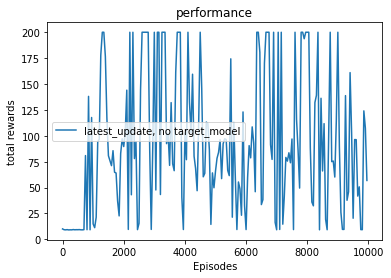

In [10]:
# DQN without a replay buffer and without a target network. This is just standard Q-learning with a function approximator. 
# The corresponding parameters are: memory_size = 1, update_steps = 1, batch_size = 1, use_target_model = False

hyperparams_CartPole = {
    'epsilon_decay_steps' : 100000, 
    'final_epsilon' : 0.1,
    'batch_size' : 1, 
    'update_steps' : 1, 
    'memory_size' : 1, 
    'beta' : 0.99, 
    'model_replace_freq' : 2000,
    'learning_rate' : 0.0003,
    'use_target_model': False
}

training_episodes, test_interval = 10000, 50
agent = DQN_agent(env_CartPole, hyperparams_CartPole)
result = agent.learn_and_evaluate(training_episodes, test_interval)
plot_result(result, test_interval, ["latest_update, no target_model"])

Training:   8%|▊         | 4/50 [00:00<00:01, 39.25it/s]

10.566666666666666


Training:  10%|█         | 5/50 [00:00<00:01, 39.06it/s]

9.566666666666666


Training:   6%|▌         | 3/50 [00:00<00:01, 27.00it/s]

11.433333333333334


Training:  10%|█         | 5/50 [00:00<00:01, 37.97it/s]

16.3


Training:   8%|▊         | 4/50 [00:00<00:01, 39.34it/s]

9.266666666666667


Training:   6%|▌         | 3/50 [00:00<00:01, 23.76it/s]

9.166666666666666


Training:   8%|▊         | 4/50 [00:00<00:01, 31.07it/s]

70.93333333333334


Training:  10%|█         | 5/50 [00:00<00:01, 43.98it/s]

12.066666666666666


Training:   6%|▌         | 3/50 [00:00<00:01, 26.16it/s]

46.733333333333334


Training:   4%|▍         | 2/50 [00:00<00:03, 13.24it/s]

11.0


Training:   4%|▍         | 2/50 [00:00<00:02, 19.27it/s]

9.333333333333334


Training:  10%|█         | 5/50 [00:00<00:00, 49.63it/s]

131.96666666666667


Training:   4%|▍         | 2/50 [00:00<00:02, 17.56it/s]

171.1


Training:   8%|▊         | 4/50 [00:00<00:01, 23.21it/s]

165.73333333333332


Training:  10%|█         | 5/50 [00:00<00:01, 44.39it/s]

171.0


Training:   6%|▌         | 3/50 [00:00<00:01, 24.27it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.95it/s]

198.8


Training:   6%|▌         | 3/50 [00:00<00:01, 27.19it/s]

156.8


Training:   6%|▌         | 3/50 [00:00<00:01, 25.82it/s]

180.26666666666668


Training:   0%|          | 0/50 [00:00<?, ?it/s]

197.5


Training:   6%|▌         | 3/50 [00:00<00:02, 21.14it/s]

124.53333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 16.22it/s]

163.66666666666666


Training:   2%|▏         | 1/50 [00:00<00:05,  8.59it/s]

164.23333333333332


Training:   4%|▍         | 2/50 [00:00<00:02, 19.86it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.34it/s]

120.36666666666666


Training:   2%|▏         | 1/50 [00:00<00:06,  7.95it/s]

134.83333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

106.6


Training:   0%|          | 0/50 [00:00<?, ?it/s]

98.3


Training:   4%|▍         | 2/50 [00:00<00:03, 14.95it/s]

133.06666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

99.0


Training:  10%|█         | 5/50 [00:00<00:00, 45.69it/s]

96.66666666666667


Training:   6%|▌         | 3/50 [00:00<00:02, 17.36it/s]

97.96666666666667


Training:   4%|▍         | 2/50 [00:00<00:03, 14.56it/s]

91.7


Training:   2%|▏         | 1/50 [00:00<00:05,  9.20it/s]

91.33333333333333


Training:   2%|▏         | 1/50 [00:00<00:07,  6.40it/s]

104.6


Training:   4%|▍         | 2/50 [00:00<00:03, 14.10it/s]

100.46666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  9.04it/s]

123.03333333333333


Training:   8%|▊         | 4/50 [00:00<00:01, 26.56it/s]

124.4


Training:   4%|▍         | 2/50 [00:00<00:03, 12.69it/s]

116.86666666666666


Training:   8%|▊         | 4/50 [00:00<00:01, 32.16it/s]

111.76666666666667


Training:   6%|▌         | 3/50 [00:00<00:01, 25.46it/s]

63.2


Training:   0%|          | 0/50 [00:00<?, ?it/s]

109.33333333333333


Training:   6%|▌         | 3/50 [00:00<00:02, 22.28it/s]

39.9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

21.6


Training:   0%|          | 0/50 [00:00<?, ?it/s]

153.16666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

116.3


Training:   0%|          | 0/50 [00:00<?, ?it/s]

40.666666666666664


Training:   0%|          | 0/50 [00:00<?, ?it/s]

173.0


Training:   8%|▊         | 4/50 [00:00<00:01, 28.12it/s]

25.2


Training:  10%|█         | 5/50 [00:00<00:01, 44.45it/s]

16.766666666666666


Training:   2%|▏         | 1/50 [00:00<00:08,  5.54it/s]

197.86666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

120.03333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

96.73333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

165.1


Training:   2%|▏         | 1/50 [00:00<00:09,  5.07it/s]

116.76666666666667


Training:  10%|█         | 5/50 [00:00<00:00, 47.53it/s]

16.133333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

130.0


Training:  10%|█         | 5/50 [00:00<00:00, 47.12it/s]

16.7


Training:   0%|          | 0/50 [00:00<?, ?it/s]

32.0


Training:   2%|▏         | 1/50 [00:00<00:08,  5.87it/s]

105.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

136.33333333333334


Training:   2%|▏         | 1/50 [00:00<00:08,  5.45it/s]

105.9


Training:   2%|▏         | 1/50 [00:00<00:05,  8.48it/s]

69.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  8.89it/s]

85.73333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 18.24it/s]

22.333333333333332


Training:  10%|█         | 5/50 [00:00<00:01, 44.97it/s]

13.333333333333334


Training:  10%|█         | 5/50 [00:00<00:00, 45.91it/s]

13.066666666666666


Training:   8%|▊         | 4/50 [00:00<00:01, 27.58it/s]

28.6


Training:   6%|▌         | 3/50 [00:00<00:01, 29.44it/s]

17.4


Training:   4%|▍         | 2/50 [00:00<00:03, 13.15it/s]

71.56666666666666


Training:   2%|▏         | 1/50 [00:00<00:06,  7.73it/s]

63.5


Training:   2%|▏         | 1/50 [00:00<00:05,  8.99it/s]

79.66666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

121.06666666666666


Training:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

134.4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

199.8


Training:   0%|          | 0/50 [00:00<?, ?it/s]

146.4


Training:   2%|▏         | 1/50 [00:00<00:07,  6.63it/s]

99.43333333333334


Training:   8%|▊         | 4/50 [00:00<00:01, 37.62it/s]

158.16666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

92.56666666666666


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 69.98it/s]


107.96666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

101.76666666666667


Training:   6%|▌         | 3/50 [00:00<00:01, 28.64it/s]

22.966666666666665


Training:   2%|▏         | 1/50 [00:00<00:08,  5.55it/s]

102.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

122.53333333333333


Training:   6%|▌         | 3/50 [00:00<00:01, 29.73it/s]

24.0


Training:   4%|▍         | 2/50 [00:00<00:02, 16.15it/s]

154.66666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

98.06666666666666


Training:   0%|          | 0/50 [00:00<?, ?it/s]

133.13333333333333


Training:   2%|▏         | 1/50 [00:00<00:09,  5.28it/s]

103.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

103.13333333333334


Training:   4%|▍         | 2/50 [00:00<00:02, 19.81it/s]

44.86666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

147.43333333333334


Training:   2%|▏         | 1/50 [00:00<00:09,  5.34it/s]

154.8


Training:   6%|▌         | 3/50 [00:00<00:01, 28.14it/s]

23.533333333333335


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

12.966666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

127.13333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:  10%|█         | 5/50 [00:00<00:00, 45.05it/s]

21.933333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

17.466666666666665


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

106.9


Training:   4%|▍         | 2/50 [00:00<00:02, 17.55it/s]

40.86666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

130.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

17.933333333333334


Training:   4%|▍         | 2/50 [00:00<00:03, 15.88it/s]

52.766666666666666


Training:   4%|▍         | 2/50 [00:00<00:03, 13.75it/s]

50.56666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

41.2


Training:   0%|          | 0/50 [00:00<?, ?it/s]

17.9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

109.83333333333333


Training:   4%|▍         | 2/50 [00:00<00:04, 11.06it/s]

74.13333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

43.06666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

65.3


Training:  10%|█         | 5/50 [00:00<00:01, 44.94it/s]

17.866666666666667


Training:   8%|▊         | 4/50 [00:00<00:01, 33.81it/s]

14.666666666666666


Training:   2%|▏         | 1/50 [00:00<00:08,  6.04it/s]

35.56666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

27.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.89it/s]

108.7


Training:   2%|▏         | 1/50 [00:00<00:07,  6.51it/s]

115.2


Training:   2%|▏         | 1/50 [00:00<00:07,  6.88it/s]

31.666666666666668


Training:   0%|          | 0/50 [00:00<?, ?it/s]

136.73333333333332


Training:   2%|▏         | 1/50 [00:00<00:05,  9.59it/s]

65.9


Training:   4%|▍         | 2/50 [00:00<00:02, 16.45it/s]

197.66666666666666


Training:   4%|▍         | 2/50 [00:00<00:02, 16.20it/s]

26.6


Training:   4%|▍         | 2/50 [00:00<00:04, 11.03it/s]

194.23333333333332


Training:   4%|▍         | 2/50 [00:00<00:02, 19.15it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

96.13333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

45.0


Training:  10%|█         | 5/50 [00:00<00:01, 32.30it/s]

10.6


Training:   2%|▏         | 1/50 [00:00<00:08,  5.99it/s]

127.16666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

168.73333333333332


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.57it/s]

83.6


Training:   8%|▊         | 4/50 [00:00<00:01, 27.79it/s]

74.4


Training:   2%|▏         | 1/50 [00:00<00:07,  6.30it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  5.91it/s]

200.0


Training:   8%|▊         | 4/50 [00:00<00:01, 35.33it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 12.15it/s]

62.56666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

11.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

38.733333333333334


Training:  12%|█▏        | 6/50 [00:00<00:00, 52.04it/s]

11.7


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.22it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:09,  5.44it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

46.13333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.51it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:04,  9.91it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

81.76666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

58.666666666666664


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.54it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

187.93333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   8%|▊         | 4/50 [00:00<00:01, 35.14it/s]

19.866666666666667


Training:   0%|          | 0/50 [00:00<?, ?it/s]

52.766666666666666


Training:  10%|█         | 5/50 [00:00<00:00, 45.71it/s]

26.666666666666668


Training:   0%|          | 0/50 [00:00<?, ?it/s]

13.4


Training:  10%|█         | 5/50 [00:00<00:01, 44.59it/s]

13.133333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

143.6


Training:   2%|▏         | 1/50 [00:00<00:07,  6.20it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

59.8


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 13.13it/s]

20.9


Training:   8%|▊         | 4/50 [00:00<00:01, 37.43it/s]

18.9


Training:   0%|          | 0/50 [00:00<?, ?it/s]

49.93333333333333


Training:   6%|▌         | 3/50 [00:00<00:01, 29.52it/s]

17.233333333333334


Training:   0%|          | 0/50 [00:00<?, ?it/s]

86.63333333333334


Training:   4%|▍         | 2/50 [00:00<00:03, 12.96it/s]

25.433333333333334


Training:  12%|█▏        | 6/50 [00:00<00:00, 54.03it/s]

11.033333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 18.85it/s]

157.4


Training:   4%|▍         | 2/50 [00:00<00:02, 16.67it/s]

176.13333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  9.12it/s]

194.03333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.91it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

13.733333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 17.90it/s]

162.53333333333333


Training:   6%|▌         | 3/50 [00:00<00:01, 28.91it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 11.54it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

14.633333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:02, 19.43it/s]

200.0


Training:   6%|▌         | 3/50 [00:00<00:02, 19.22it/s]

200.0


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 15.87it/s]

55.4


Training:   0%|          | 0/50 [00:00<?, ?it/s]

98.33333333333333


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 37.21it/s]

200.0

Learning Performance:



<Figure size 432x288 with 0 Axes>

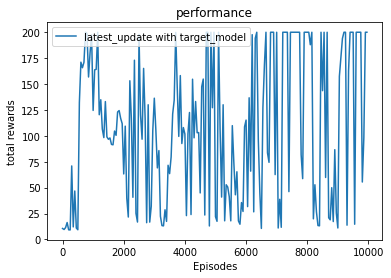

In [11]:
# DQN without a replay buffer (but including the target network).
# The corresponding parameters are: memory_size = 1, update_steps = 1, batch_size = 1, use_target_model = True

hyperparams_CartPole = {
    'epsilon_decay_steps' : 100000, 
    'final_epsilon' : 0.1,
    'batch_size' : 1, 
    'update_steps' : 1, 
    'memory_size' : 1, 
    'beta' : 0.99, 
    'model_replace_freq' : 2000,
    'learning_rate' : 0.0003,
    'use_target_model': True
}

training_episodes, test_interval = 10000, 50
agent = DQN_agent(env_CartPole, hyperparams_CartPole)
result = agent.learn_and_evaluate(training_episodes, test_interval)
plot_result(result, test_interval, ["latest_update with target_model"])


Training:  24%|██▍       | 12/50 [00:00<00:00, 116.59it/s]

9.3


Training:  28%|██▊       | 14/50 [00:00<00:00, 138.10it/s]

10.9


Training:  32%|███▏      | 16/50 [00:00<00:00, 159.37it/s]

11.033333333333333


Training:  24%|██▍       | 12/50 [00:00<00:00, 110.16it/s]

9.266666666666667


Training:  28%|██▊       | 14/50 [00:00<00:00, 128.02it/s]

9.533333333333333


Training:  24%|██▍       | 12/50 [00:00<00:00, 113.82it/s]

9.266666666666667


Training:  24%|██▍       | 12/50 [00:00<00:00, 111.43it/s]

9.366666666666667


Training:  30%|███       | 15/50 [00:00<00:00, 147.83it/s]

9.366666666666667


Training:  28%|██▊       | 14/50 [00:00<00:00, 136.88it/s]

9.266666666666667


Training:  26%|██▌       | 13/50 [00:00<00:00, 129.74it/s]

9.2


Training:  30%|███       | 15/50 [00:00<00:00, 149.56it/s]

9.266666666666667


Training:  24%|██▍       | 12/50 [00:00<00:00, 119.75it/s]

9.266666666666667


Training:  32%|███▏      | 16/50 [00:00<00:00, 151.95it/s]

9.2


Training:  30%|███       | 15/50 [00:00<00:00, 147.34it/s]

9.166666666666666


Training:  22%|██▏       | 11/50 [00:00<00:00, 101.63it/s]

9.633333333333333


Training:  26%|██▌       | 13/50 [00:00<00:00, 127.57it/s]

9.433333333333334


Training:  26%|██▌       | 13/50 [00:00<00:00, 127.67it/s]

9.166666666666666


Training:  22%|██▏       | 11/50 [00:00<00:00, 84.33it/s]

9.333333333333334


Training:  26%|██▌       | 13/50 [00:00<00:00, 126.45it/s]

9.4


Training:  26%|██▌       | 13/50 [00:00<00:00, 109.73it/s]

9.3


Training:  22%|██▏       | 11/50 [00:00<00:00, 107.29it/s]

9.4


Training:  22%|██▏       | 11/50 [00:00<00:00, 92.95it/s]

9.233333333333333


Training:  18%|█▊        | 9/50 [00:00<00:00, 87.82it/s]

9.4


Training:  26%|██▌       | 13/50 [00:00<00:00, 129.00it/s]

9.366666666666667


Training:  26%|██▌       | 13/50 [00:00<00:00, 127.86it/s]

9.366666666666667


Training:  24%|██▍       | 12/50 [00:00<00:00, 115.42it/s]

9.3


Training:  26%|██▌       | 13/50 [00:00<00:00, 128.29it/s]

9.166666666666666


Training:  22%|██▏       | 11/50 [00:00<00:00, 104.47it/s]

9.166666666666666


Training:  28%|██▊       | 14/50 [00:00<00:00, 137.15it/s]

9.3


Training:  34%|███▍      | 17/50 [00:00<00:00, 167.64it/s]

9.5


Training:  24%|██▍       | 12/50 [00:00<00:00, 113.63it/s]

9.3


Training:  34%|███▍      | 17/50 [00:00<00:00, 159.92it/s]

9.3


Training:  36%|███▌      | 18/50 [00:00<00:00, 178.74it/s]

9.366666666666667


Training:  26%|██▌       | 13/50 [00:00<00:00, 121.21it/s]

9.466666666666667


Training:  30%|███       | 15/50 [00:00<00:00, 146.48it/s]

9.6


Training:  34%|███▍      | 17/50 [00:00<00:00, 164.74it/s]

9.466666666666667


Training:  28%|██▊       | 14/50 [00:00<00:00, 137.59it/s]

9.566666666666666


Training:  26%|██▌       | 13/50 [00:00<00:00, 127.29it/s]

9.3


Training:  32%|███▏      | 16/50 [00:00<00:00, 154.19it/s]

9.4


Training:  28%|██▊       | 14/50 [00:00<00:00, 130.39it/s]

9.366666666666667


Training:  30%|███       | 15/50 [00:00<00:00, 149.60it/s]

9.266666666666667


Training:  32%|███▏      | 16/50 [00:00<00:00, 157.22it/s]

9.266666666666667


Training:  32%|███▏      | 16/50 [00:00<00:00, 155.78it/s]

9.566666666666666


Training:  34%|███▍      | 17/50 [00:00<00:00, 162.18it/s]

9.666666666666666


Training:  36%|███▌      | 18/50 [00:00<00:00, 173.86it/s]

9.6


Training:  38%|███▊      | 19/50 [00:00<00:00, 167.60it/s]

9.5


Training:  36%|███▌      | 18/50 [00:00<00:00, 174.94it/s]

9.266666666666667


Training:  40%|████      | 20/50 [00:00<00:00, 189.00it/s]

9.266666666666667


Training:  34%|███▍      | 17/50 [00:00<00:00, 169.75it/s]

9.066666666666666


Training:  34%|███▍      | 17/50 [00:00<00:00, 156.95it/s]

9.3


Training:  30%|███       | 15/50 [00:00<00:00, 148.03it/s]

9.4


Training:  36%|███▌      | 18/50 [00:00<00:00, 178.71it/s]

9.2


Training:  38%|███▊      | 19/50 [00:00<00:00, 179.12it/s]

9.5


Training:  32%|███▏      | 16/50 [00:00<00:00, 159.09it/s]

9.666666666666666


Training:  42%|████▏     | 21/50 [00:00<00:00, 209.70it/s]

9.3


Training:  38%|███▊      | 19/50 [00:00<00:00, 184.95it/s]

9.266666666666667


Training:  38%|███▊      | 19/50 [00:00<00:00, 180.50it/s]

9.2


Training:  36%|███▌      | 18/50 [00:00<00:00, 178.54it/s]

9.3


Training:  36%|███▌      | 18/50 [00:00<00:00, 170.71it/s]

9.4


Training:  32%|███▏      | 16/50 [00:00<00:00, 155.74it/s]

9.466666666666667


Training:  30%|███       | 15/50 [00:00<00:00, 143.02it/s]

9.333333333333334


Training:  28%|██▊       | 14/50 [00:00<00:00, 136.02it/s]

9.1


Training:  32%|███▏      | 16/50 [00:00<00:00, 152.08it/s]

9.233333333333333


Training:  28%|██▊       | 14/50 [00:00<00:00, 135.67it/s]

9.3


Training:  30%|███       | 15/50 [00:00<00:00, 146.80it/s]

9.366666666666667


Training:  30%|███       | 15/50 [00:00<00:00, 148.84it/s]

9.1


Training:  30%|███       | 15/50 [00:00<00:00, 143.98it/s]

9.466666666666667


Training:  28%|██▊       | 14/50 [00:00<00:00, 139.87it/s]

9.366666666666667


Training:  28%|██▊       | 14/50 [00:00<00:00, 137.88it/s]

9.533333333333333


Training:  32%|███▏      | 16/50 [00:00<00:00, 157.55it/s]

9.233333333333333


Training:  24%|██▍       | 12/50 [00:00<00:00, 112.05it/s]

17.133333333333333


Training:  10%|█         | 5/50 [00:00<00:01, 44.87it/s]

19.866666666666667


Training:  14%|█▍        | 7/50 [00:00<00:00, 66.25it/s]

74.06666666666666


Training:  18%|█▊        | 9/50 [00:00<00:00, 82.60it/s]

19.566666666666666


Training:  12%|█▏        | 6/50 [00:00<00:00, 54.03it/s]

24.833333333333332


Training:  14%|█▍        | 7/50 [00:00<00:00, 63.92it/s]

23.066666666666666


Training:  14%|█▍        | 7/50 [00:00<00:00, 60.33it/s]

30.433333333333334


Training:  12%|█▏        | 6/50 [00:00<00:00, 54.93it/s]

58.1


Training:  20%|██        | 10/50 [00:00<00:00, 70.39it/s]

18.7


Training:  14%|█▍        | 7/50 [00:00<00:00, 54.57it/s]

26.066666666666666


Training:   8%|▊         | 4/50 [00:00<00:01, 38.79it/s]

15.166666666666666


Training:  16%|█▌        | 8/50 [00:00<00:00, 76.25it/s]

112.73333333333333


Training:  10%|█         | 5/50 [00:00<00:00, 49.65it/s]

145.7


Training:  24%|██▍       | 12/50 [00:00<00:00, 115.72it/s]

17.3


Training:   8%|▊         | 4/50 [00:00<00:01, 37.00it/s]

59.233333333333334


Training:   4%|▍         | 2/50 [00:00<00:02, 16.76it/s]

172.4


Training:   2%|▏         | 1/50 [00:00<00:05,  8.28it/s]

181.4


Training:   4%|▍         | 2/50 [00:00<00:03, 12.60it/s]

143.83333333333334


Training:   2%|▏         | 1/50 [00:00<00:07,  6.82it/s]

200.0


Training:  18%|█▊        | 9/50 [00:00<00:00, 88.83it/s]

25.2


Training:  10%|█         | 5/50 [00:00<00:01, 42.16it/s]

17.166666666666668


Training:   6%|▌         | 3/50 [00:00<00:01, 25.91it/s]

88.63333333333334


Training:   2%|▏         | 1/50 [00:00<00:06,  7.38it/s]

196.36666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  9.16it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.60it/s]

48.4


Training:  20%|██        | 10/50 [00:00<00:00, 94.69it/s]

17.5


Training:  26%|██▌       | 13/50 [00:00<00:00, 96.84it/s]

10.233333333333333


Training:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.38it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.31it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.58it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:02, 17.96it/s]

38.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  9.72it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.91it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.81it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.05it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.50it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.78it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.11it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.26it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.59it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.81it/s]

200.0


Training:  10%|█         | 5/50 [00:00<00:01, 34.70it/s]

25.233333333333334


Training:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.11it/s]

200.0


Training:  36%|███▌      | 18/50 [00:00<00:00, 176.36it/s]

9.533333333333333


Training:  26%|██▌       | 13/50 [00:00<00:00, 127.75it/s]

19.0


Training:   4%|▍         | 2/50 [00:00<00:04, 11.50it/s]

184.2


Training:   2%|▏         | 1/50 [00:00<00:06,  7.89it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.83it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.34it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  5.46it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.00it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.72it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  8.00it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:04,  9.91it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.83it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.29it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.97it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.47it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.68it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.74it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.08it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.47it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.04it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.04it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.35it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.63it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.86it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.55it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.42it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  8.17it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.19it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.79it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.45it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.47it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.29it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.99it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.36it/s]

192.33333333333334


Training:   2%|▏         | 1/50 [00:00<00:05,  8.36it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.73it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.43it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.57it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.41it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.54it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.56it/s]

200.0


Training:  16%|█▌        | 8/50 [00:00<00:00, 56.76it/s]

12.333333333333334


Training:   4%|▍         | 2/50 [00:00<00:04, 10.75it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.22it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.18it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.69it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.68it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.95it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.49it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.40it/s]

200.0


Training:  14%|█▍        | 7/50 [00:00<00:00, 46.83it/s]

12.9


Training:   2%|▏         | 1/50 [00:00<00:05,  9.39it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.10it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.60it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.73it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.65it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.57it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.58it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 15.21it/s]

169.5


Training:   2%|▏         | 1/50 [00:00<00:06,  7.88it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

149.1


Training:   2%|▏         | 1/50 [00:00<00:05,  9.27it/s]

182.16666666666666


Training:   4%|▍         | 2/50 [00:00<00:03, 13.75it/s]

156.4


Training:   2%|▏         | 1/50 [00:00<00:05,  9.08it/s]

193.93333333333334


Training:   2%|▏         | 1/50 [00:00<00:05,  8.29it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.20it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.25it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.51it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.52it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.23it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.12it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.26it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.40it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.86it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.70it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.21it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 11.75it/s]

117.46666666666667


Training:   2%|▏         | 1/50 [00:00<00:06,  7.26it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.07it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.61it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.28it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.65it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:02, 19.16it/s]

180.3


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 51.33it/s]

148.56666666666666

Learning Performance:



<Figure size 432x288 with 0 Axes>

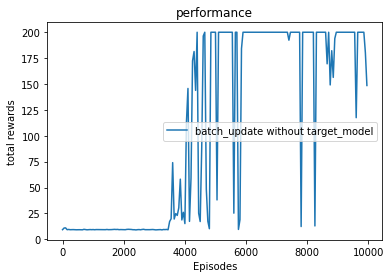

In [14]:
# DQN with a replay buffer, but without a target network.
# Here you set use_target_model = False and otherwise set the replay memory parameters to the above suggested values

hyperparams_CartPole = {
    'epsilon_decay_steps' : 100000, 
    'final_epsilon' : 0.1,
    'batch_size' : 32, 
    'update_steps' : 10, 
    'memory_size' : 2000, 
    'beta' : 0.99, 
    'model_replace_freq' : 2000,
    'learning_rate' : 0.0003,
    'use_target_model': False
}

training_episodes, test_interval = 10000, 50
agent = DQN_agent(env_CartPole, hyperparams_CartPole)
result = agent.learn_and_evaluate(training_episodes, test_interval)
plot_result(result, test_interval, ["batch_update without target_model"])

Training:  34%|███▍      | 17/50 [00:00<00:00, 161.09it/s]

9.333333333333334


Training:  22%|██▏       | 11/50 [00:00<00:00, 109.17it/s]

15.933333333333334


Training:  34%|███▍      | 17/50 [00:00<00:00, 157.11it/s]

9.466666666666667


Training:  24%|██▍       | 12/50 [00:00<00:00, 112.46it/s]

13.666666666666666


Training:  26%|██▌       | 13/50 [00:00<00:00, 128.32it/s]

12.633333333333333


Training:  24%|██▍       | 12/50 [00:00<00:00, 116.25it/s]

11.266666666666667


Training:  26%|██▌       | 13/50 [00:00<00:00, 121.54it/s]

46.93333333333333


Training:  24%|██▍       | 12/50 [00:00<00:00, 113.26it/s]

37.53333333333333


Training:  32%|███▏      | 16/50 [00:00<00:00, 143.18it/s]

199.96666666666667


Training:  12%|█▏        | 6/50 [00:00<00:00, 58.27it/s]

200.0


Training:  10%|█         | 5/50 [00:00<00:01, 43.97it/s]

151.23333333333332


Training:   4%|▍         | 2/50 [00:00<00:03, 14.40it/s]

200.0


Training:   6%|▌         | 3/50 [00:00<00:01, 28.27it/s]

189.96666666666667


Training:  10%|█         | 5/50 [00:00<00:00, 47.64it/s]

200.0


Training:  18%|█▊        | 9/50 [00:00<00:00, 84.05it/s]

200.0


Training:  14%|█▍        | 7/50 [00:00<00:00, 65.64it/s]

184.7


Training:  16%|█▌        | 8/50 [00:00<00:00, 78.69it/s]

200.0


Training:  14%|█▍        | 7/50 [00:00<00:00, 64.57it/s]

171.56666666666666


Training:  10%|█         | 5/50 [00:00<00:00, 45.20it/s]

198.73333333333332


Training:   4%|▍         | 2/50 [00:00<00:02, 18.57it/s]

200.0


Training:  14%|█▍        | 7/50 [00:00<00:00, 66.56it/s]

200.0


Training:   8%|▊         | 4/50 [00:00<00:01, 35.71it/s]

200.0


Training:   6%|▌         | 3/50 [00:00<00:01, 24.77it/s]

199.7


Training:  10%|█         | 5/50 [00:00<00:00, 49.16it/s]

183.6


Training:   6%|▌         | 3/50 [00:00<00:02, 21.87it/s]

200.0


Training:   8%|▊         | 4/50 [00:00<00:01, 39.84it/s]

200.0


Training:   6%|▌         | 3/50 [00:00<00:02, 21.57it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 12.37it/s]

199.03333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  9.77it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  6.04it/s]

175.06666666666666


Training:   2%|▏         | 1/50 [00:00<00:04,  9.95it/s]

199.43333333333334


Training:   2%|▏         | 1/50 [00:00<00:06,  7.78it/s]

184.53333333333333


Training:  10%|█         | 5/50 [00:00<00:01, 33.87it/s]

22.866666666666667


Training:  10%|█         | 5/50 [00:00<00:01, 29.95it/s]

16.6


Training:   4%|▍         | 2/50 [00:00<00:03, 13.19it/s]

112.8


Training:  18%|█▊        | 9/50 [00:00<00:00, 80.66it/s]

19.133333333333333


Training:  10%|█         | 5/50 [00:00<00:00, 47.05it/s]

93.53333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 17.49it/s]

106.1


Training:   2%|▏         | 1/50 [00:00<00:05,  9.66it/s]

110.06666666666666


Training:   4%|▍         | 2/50 [00:00<00:03, 12.46it/s]

157.36666666666667


Training:   2%|▏         | 1/50 [00:00<00:05,  8.89it/s]

190.73333333333332


Training:   4%|▍         | 2/50 [00:00<00:02, 18.12it/s]

104.63333333333334


Training:   8%|▊         | 4/50 [00:00<00:01, 37.04it/s]

19.6


Training:   4%|▍         | 2/50 [00:00<00:03, 13.06it/s]

119.5


Training:   8%|▊         | 4/50 [00:00<00:01, 34.27it/s]

15.566666666666666


Training:   4%|▍         | 2/50 [00:00<00:02, 17.85it/s]

101.0


Training:   4%|▍         | 2/50 [00:00<00:03, 12.32it/s]

126.8


Training:   6%|▌         | 3/50 [00:00<00:02, 19.71it/s]

118.06666666666666


Training:   4%|▍         | 2/50 [00:00<00:03, 12.61it/s]

126.73333333333333


Training:   4%|▍         | 2/50 [00:00<00:02, 16.44it/s]

126.6


Training:   2%|▏         | 1/50 [00:00<00:05,  9.54it/s]

163.5


Training:   4%|▍         | 2/50 [00:00<00:03, 12.04it/s]

168.53333333333333


Training:   2%|▏         | 1/50 [00:00<00:06,  7.56it/s]

176.96666666666667


Training:   2%|▏         | 1/50 [00:00<00:06,  7.72it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:02, 18.20it/s]

108.93333333333334


Training:   4%|▍         | 2/50 [00:00<00:04, 11.12it/s]

94.0


Training:   4%|▍         | 2/50 [00:00<00:03, 12.17it/s]

184.63333333333333


Training:   2%|▏         | 1/50 [00:00<00:05,  8.21it/s]

123.06666666666666


Training:   8%|▊         | 4/50 [00:00<00:01, 28.70it/s]

15.8


Training:   2%|▏         | 1/50 [00:00<00:05,  8.46it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.40it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 13.27it/s]

66.83333333333333


Training:   2%|▏         | 1/50 [00:00<00:06,  7.73it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.59it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 12.07it/s]

108.63333333333334


Training:   4%|▍         | 2/50 [00:00<00:04, 11.61it/s]

123.43333333333334


Training:   4%|▍         | 2/50 [00:00<00:02, 19.57it/s]

137.1


Training:   2%|▏         | 1/50 [00:00<00:05,  9.16it/s]

197.06666666666666


Training:   2%|▏         | 1/50 [00:00<00:06,  7.03it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.61it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.63it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.34it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.43it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.46it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.29it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.11it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.96it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.49it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.61it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.34it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.91it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.23it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.57it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.11it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.27it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.31it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.45it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.59it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 11.36it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.05it/s]

200.0


Training:  30%|███       | 15/50 [00:00<00:00, 143.61it/s]

10.6


Training:   0%|          | 0/50 [00:00<?, ?it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.00it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.83it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.04it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.07it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.91it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  8.12it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.26it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.14it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.16it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.97it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.62it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.64it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.51it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.25it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.80it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.62it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.51it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.00it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  8.08it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.69it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.75it/s]

200.0


Training:   6%|▌         | 3/50 [00:00<00:02, 18.74it/s]

193.76666666666668


Training:   4%|▍         | 2/50 [00:00<00:04, 11.97it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.69it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.82it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.53it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.63it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.49it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.98it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.18it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.72it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.44it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:03, 12.22it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  8.00it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.72it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.50it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.92it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.96it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.60it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.29it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.18it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.74it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.15it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.08it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.21it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.30it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.01it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.01it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.17it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.45it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.28it/s]

200.0


Training:   4%|▍         | 2/50 [00:00<00:04, 10.53it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.73it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.47it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.36it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.62it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.86it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.34it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.55it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.97it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.38it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.91it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.62it/s]

199.86666666666667


Training:   2%|▏         | 1/50 [00:00<00:06,  7.30it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.92it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.77it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.14it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.86it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.12it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.55it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.08it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.39it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.84it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.20it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.35it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.45it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.01it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.52it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.70it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.89it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.42it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.77it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.94it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:08,  6.07it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.35it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.97it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.25it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.17it/s]

166.43333333333334


Training:   2%|▏         | 1/50 [00:00<00:06,  7.33it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.57it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.37it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.16it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.97it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.69it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.34it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.84it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  7.23it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.21it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:06,  8.16it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.38it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.48it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.22it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.24it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  8.65it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:05,  9.00it/s]

200.0


Training:   2%|▏         | 1/50 [00:00<00:07,  6.55it/s]

200.0


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 37.61it/s]

200.0

Learning Performance:



<Figure size 432x288 with 0 Axes>

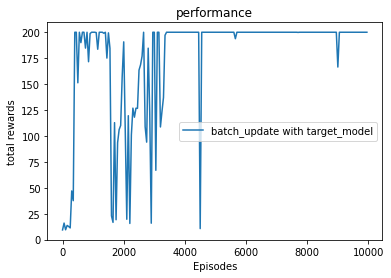

In [13]:
# Full DQN

hyperparams_CartPole = {
    'epsilon_decay_steps' : 100000, 
    'final_epsilon' : 0.1,
    'batch_size' : 32, 
    'update_steps' : 10, 
    'memory_size' : 2000, 
    'beta' : 0.99, 
    'model_replace_freq' : 2000,
    'learning_rate' : 0.0003,
    'use_target_model': True
}

training_episodes, test_interval = 10000, 50
agent = DQN_agent(env_CartPole, hyperparams_CartPole)
result = agent.learn_and_evaluate(training_episodes, test_interval)
plot_result(result, test_interval, ["batch_update with target_model"])

***
# Part 2: Distributed DQN
***

Here you will implement a distributed version of the above DQN approach. The distribution approach can be the same as that used for the table-based distribution Q-learning algorithm from homework 3.

## init Ray

In [ ]:
ray.shutdown()
ray.init(include_webui=False, ignore_reinit_error=True, redis_max_memory=500000000, object_store_memory=5000000000)

## Distributed DQN agent
The idea is to speedup learning by creating actors to collect data and a model_server to update the neural network model.
- Collector: There is a simulator inside each collector. Their job is to collect exprience from the simulator, and send them to the memory server. They follow the explore_or_exploit policy, getting greedy action from model server. Also, call update function of model server to update the model.  
- Evaluator: There is a simulator inside the evaluator. It is called by the the Model Server, taking eval_model from it, and test its performance.
- Model Server: Stores the evalation and target networks. It Takes experiences from Memory Server and updates the Q-network, also replacing target Q-network periodically. It also interfaces to the evaluator periodically. 
- Memory Server: It is used to store/sample experience relays.

An image of this architecture is below. 

For this part, you should use our custom_cartpole as your enviroment. This version of cartpole is slower, which allows for the benefits of distributed experience collection to be observed. In particular, the time to generate an experience tuple needs to be non-trivial compared to the time needed to do a neural network model update. 

<span style="color:green">It is better to run the distributed DQN agent in exclusive node, not in Jupyter notebook</span>
```
Store all of your distrited DQN code into a python file.
ssh colfax (get access to the Devcloud on terminal)
qsub -I -lselect=1
python3 distributed_dqn.py
```

<img src="distributed DQN.png">

For this part of the homework you need to submit your code for distributed DQN and run experiments that vary the number of workers involved. Produce some learning curves and timing results and discuss your observations. 

In [ ]:
from memory_remote import ReplayBuffer_remote
from dqn_model import _DQNModel
import torch
from custom_cartpole import CartPoleEnv

In [ ]:
# Set the Env name and action space for CartPole
ENV_NAME = 'CartPole_distributed'

# Set result saveing floder
result_floder = ENV_NAME + "_distributed"
result_file = ENV_NAME + "/results.txt"
if not os.path.isdir(result_floder):
    os.mkdir(result_floder)
torch.set_num_threads(12)